In [7]:
%cd ~/Dropbox/Stanford/CS_224N/Final_Project

/Users/elissali/Dropbox/Stanford/CS_224N/Final_Project


In [8]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import mixture
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

sns.set(color_codes=True)

In [9]:
data_df = pd.read_csv('./data_2.csv', sep=',')
means_df = pd.read_csv('./sentence_means_var.csv', sep=',')
annotated_df = pd.read_csv('./hand_annotated.csv', sep=',')
distrib_df = pd.read_csv('./datasets/seed_0/test_db.csv', sep=',')


def func(tgrep):
    if tgrep[-3:] == ':00':
        return tgrep[:-3]
    else: return tgrep
annotated_df['tgrep.id'] = annotated_df['tgrep.id'].apply(func)
means_df['tgrep.id'] = means_df['tgrep.id'].apply(func)

In [10]:
distrib_df[0:6]

,Item,Mean,Var,Alpha,Beta,Params,Raw_Distrib,Discrete_Distrib,Sentence
0,164352:51,0.546667,0.119333,0.492825,0.362092,(0.4928251755022261 0.3620915386852378),[0.33 0.84 0.86 0.76 0.99 0.31 0.74 0.0...,[0.11111111 0. 0.22222222 0. 0...,i think in some cases it doesn't matter if it...
1,173504:75,0.666667,0.104422,0.304365,0.169157,(0.30436478242287335 0.1691570683290402),[0.21 1.0 0.86 0.69 0.9 0.13 0.91 0.95 ...,[0.11111111 0.11111111 0.11111111 0. 0...,and if you don't you'll perish. either by the ...
2,112347:54,0.566842,0.110874,0.531796,0.351648,(0.5317960082250381 0.35164841970003324),[0.53 0.73 0.09 0.89 0.88 0.64 0.75 0.1...,[0.26315789 0. 0.05263158 0.10526316 0...,"now, my kids didn't like it because they just ..."
3,113966:144,0.451111,0.082143,1.172429,0.863586,(1.1724290563691957 0.8635857726442795),[0.37 0.43 0.35 0.86 0.7 0.02 0.36 0.1 ...,[0.22222222 0. 0.33333333 0.11111111 0...,and finally our governor at the time which who...
4,155785:58,0.508889,0.066721,0.345911,0.222104,(0.34591075051904796 0.22210411312128392),[0.66 0.73 0.53 0.72 0.83 0.63 0.16 0.1...,[0.11111111 0.22222222 0. 0.11111111 0...,and we seem to be able to get along with the...
5,9072:53:00,0.404444,0.118825,0.251853,0.401979,(0.25185309059299565 0.4019789085496089),[0.18 0.02 0.34 0.77 0.03 0.32 0.92 0.1...,[0.22222222 0.22222222 0.22222222 0. 0...,"well, i was just going to say, it's a little ..."


In [143]:
a = data_df.groupby('tgrep.id')['response_val'].apply(list)
# a.keys()

# for i, tgrep in enumerate(a.keys()):
#     print(tgrep)

## Gaussian Mixture Preprocessing

First, below is the actual distribution of scores for a sentence:

In [11]:
x = distrib_df['Raw_Distrib'][0]
x

'[0.33  0.84  0.86  0.76  0.99  0.31  0.74  0.0  0.09]'

[0.33 0.84 0.86 0.76 0.99 0.31 0.74 0.   0.09]


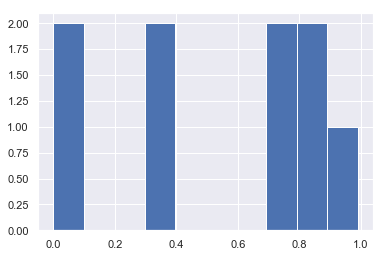

In [12]:
x = distrib_df['Raw_Distrib'][0]
x = x.strip(']')
x = x.strip('[')
x = x.split()
list_x = np.array(x, dtype=np.float32)
print(list_x)
plt.hist(list_x);

Need to reshape the list of scores so sklearn is willing to play with it (here's what it looks like):

In [13]:
list_x.reshape(-1, 1)

array([[0.33],
       [0.84],
       [0.86],
       [0.76],
       [0.99],
       [0.31],
       [0.74],
       [0.  ],
       [0.09]], dtype=float32)

Fit the sklearn Gaussian Mixture model over the actual distribution of scores, and plot what the resulting distribution looks like (using random sampling from the fitted model). This model assumes 2 components (i.e. 2 overlapping Gaussians).

https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

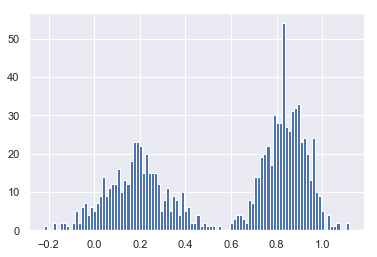

In [14]:
model = mixture.GaussianMixture(n_components=2)
fitted_model = model.fit(list_x.reshape(-1, 1))
plt.hist(fitted_model.sample(1000)[0], bins=100);   # nice semicolon = skip printing the giant array 

This isn't bad?!

Now, to get the mean and standard deviation for each component. The mean is straightforward:

In [138]:
means = fitted_model.means_.flatten()
means

array([0.18258308, 0.83801041])

Need some sorcery to get the standard deviation, but the internet says this works:
https://stackoverflow.com/questions/40874263/how-to-get-standard-deviation-from-each-components-in-sklearn-gmm-after-fit

In [16]:
cov = fitted_model.covariances_
stdevs = [ np.sqrt(  np.trace(cov[i])/2) for i in range(0,2) ]
stdevs

[0.10003483971618532, 0.06267761041495623]

As a sanity check: plot each of the component distribution PDFs (from the mean and standard deviation) to confirm that it roughly matches the component in the original Gaussian mixture.

loc is mean and scale is standard deviation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

In [17]:
stats.norm.pdf(x=means[0], loc=means[0], scale=stdevs[0])

array([3.98803338])

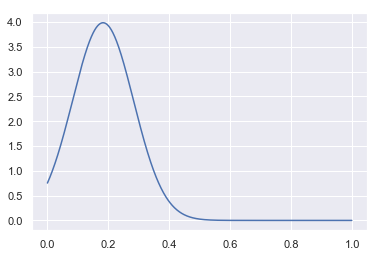

In [18]:
# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(0, 1, 0.001)
# Mean = 0, SD = 2.
plt.plot(x_axis, stats.norm.pdf(x_axis,means[0],stdevs[0]))
plt.show()

# pytorch

Normal distributions in PyTorch: https://pytorch.org/docs/stable/generated/torch.normal.html

Mixture models: https://pytorch.org/docs/stable/distributions.html#mixturesamefamily

Example of mixed Gaussian: https://data-newbie.tistory.com/514

In [25]:
import torch
from torch import distributions as D
from torch.distributions.mixture_same_family import MixtureSameFamily

In [139]:
i = 0
mean_a = torch.Tensor([means[i]])
stdev_a = torch.Tensor([stdevs[i]])     # notice the extra brackets here
comp_a = D.Normal(mean_a[0], stdev_a[0])

In [140]:
i = 1
mean_b = torch.Tensor([means[i]])
stdev_b = torch.Tensor([stdevs[i]])     # notice the extra brackets here
comp_b = D.Normal(mean_b[0], stdev_b[0])

torch.Size([2])


/Users/elissali/anaconda3/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
/Users/elissali/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


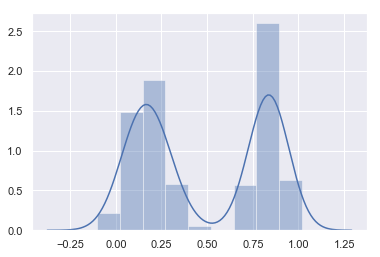

In [178]:
means = torch.cat((mean_a, mean_b))
print(means.shape)
stdevs = torch.cat((stdev_a, stdev_b))
comp = D.Normal(means, stdevs)
mix = D.Categorical(torch.ones(2,))

gmm = MixtureSameFamily(mix, comp)
sns.distplot(gmm.sample_n(1000).detach().numpy())

In [163]:
type(gmm)

torch.distributions.mixture_same_family.MixtureSameFamily

### Steps:

1. Use sklearn to fit gmm over scores for each sentence, and return (mean, standard deviation) for each component distribution `x 2` for each sentence in split_dataset.py
2. In models.py, read the component (mean, standard deviation) and fit it into a torch MixtureSameFamily distribution. 
3. In models.py, loss should be between two MixtureSameFamily distributions. 

# Scrapwork

In [156]:
def get_mixture(array):
    model = mixture.GaussianMixture(n_components=2)
    mixed_means = dict()
    mixed_stdevs = dict()
    for i, tgrep in enumerate(array.keys()):
        scores = np.array(array[tgrep], dtype=np.float32)
        fitted_model = model.fit(scores.reshape(-1, 1))
        mixed_means[tgrep] = fitted_model.means_.flatten()
        cov = fitted_model.covariances_
        mixed_stdevs[tgrep] = [ np.sqrt(  np.trace(cov[i])/2) for i in range(0,2) ]
    return mixed_means, mixed_stdevs 

In [157]:
data_df.head()

,tgrep.id,workerid,sentence_bnb,response_goodsentence,response_val,Trial,gender,age
0,362:41:00,365,"that's just a matter of defining priorities, i...",good bnb sentence,0.12,1,Female,31.0
1,362:41:00,366,"that's just a matter of defining priorities, i...",good bnb sentence,0.00,1,Male,32.0
2,362:41:00,367,"that's just a matter of defining priorities, i...",good bnb sentence,0.78,1,NaN,NaN
3,362:41:00,368,"that's just a matter of defining priorities, i...",bad bnb sentence,0.50,1,Male,36.0
4,362:41:00,369,"that's just a matter of defining priorities, i...",bad bnb sentence,0.90,1,Female,39.0


In [158]:
x = data_df.groupby('tgrep.id')['response_val'].apply(list).to_dict()   # {tgrep.id : [raw ratings]}

In [160]:
means, stds = get_mixture(x)

Some stuff on batches in distributions: https://bochang.me/blog/posts/pytorch-distributions/

In [255]:
ex_means = torch.rand([32,2])
ex_stds = torch.rand([32,2])

comp = D.Normal(ex_means, ex_stds)
comp.batch_shape

mix = D.Categorical(torch.ones(32,2,))       # I think this needs to be (32,2) instead of just (2,)

gmm = MixtureSameFamily(mix, comp)
# sns.distplot(gmm.sample_n(1000).detach().numpy())

In [257]:
gmm.sample()

tensor([ 0.1157,  1.4251,  0.0199,  1.2584,  1.1777,  0.8082,  1.2216,  0.0225,
        -0.6264,  0.7680,  0.2043,  1.7586,  1.2188,  0.4126,  1.2605,  0.6567,
         1.3509,  0.1613,  0.3255,  0.4947,  0.6710,  1.5320,  0.3120,  2.8996,
         0.6199,  0.9374,  0.5300,  0.1771,  2.9784,  0.3516,  0.0902,  0.4737])

In [256]:
type(gmm)
type(comp)
comp
gmm

MixtureSameFamily(
  Categorical(probs: torch.Size([32, 2]), logits: torch.Size([32, 2])),
  Normal(loc: torch.Size([32, 2]), scale: torch.Size([32, 2])))

## Monte Carlo? 

Can't do KL divergence on mixed Gaussians; best you can do is a Monte Carlo approximation on the bounds: https://github.com/tensorflow/probability/issues/199

More on Monte Carlo here: https://www.tensorflow.org/probability/api_docs/python/tfp/monte_carlo/expectation

Example of Monte Carlo approximation of KL divergence between GMMs here: https://stackoverflow.com/questions/26079881/kl-divergence-of-two-gmms?noredirect=1&lq=1

**TODO**: But can you even backprop through a Monte Carlo? Second paragraph of this thing says it's not possible to backprop through random samples: https://pytorch.org/docs/stable/distributions.html

### Monte Carlo attempt based on stackoverflow example
 * in skl: score_samples = weighted log probs for each sample

In [262]:
# TODO: This is broken 

def gmm_kl(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample_n(n_samples)
    log_p_X, _ = gmm_p.log_prob(X)
    log_q_X, _ = gmm_q.log_prob(X)
    return log_p_X.mean() - log_q_X.mean()

In [263]:
gmm_kl(gmm, gmm)

/Users/elissali/anaconda3/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


ValueError: too many values to unpack (expected 2)